# Deep Learning model의 class weight 조정

## DNN 이용, Class Weight 조정, OverSampling

- Data 는 이전 실습 문제와 동일한 [Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud) - Kaggle

### Kaggle Credit Card Fraud dataset 다운로드

In [87]:
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from collections import Counter
from sklearn.discriminant_analysis import StandardScaler
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import roc_auc_score, f1_score, accuracy_score, precision_score, recall_score


In [4]:
df = pd.read_csv("https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv")
print(df.head())

   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27       V28 

In [5]:
df['Class'].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

In [15]:
neg, pos = df['Class'].value_counts().values.tolist()
total = neg + pos
print(f'Number of normal transactions: {neg}')
print(f'Number of fraudulent transactions: {pos}')
print(f'Total number of transactions: {total}')
print(f'Fraudulent transaction percentage: {pos/total*100:.2f}%')


Number of normal transactions: 284315
Number of fraudulent transactions: 492
Total number of transactions: 284807
Fraudulent transaction percentage: 0.17%


### 클래스 레이블 불균형 조사

## Data 전처리

- 2 일 동안의 data가 00:00:00 부터 발생했으므로 Time을 일중 시간으로 변경 : time / 3600 초 % 24 시간  
- Amount column 은 편차가 크므로 log-scale 로 변환

In [33]:
preprocess_df = df.copy()

# Time을 일중 시간으로 변환
preprocess_df.loc[:, "Time"] = preprocess_df.loc[:, "Time"].apply(lambda x : x / 3600 % 24)

preprocess_df.head()

# Amount column 은 편차가 크므로 log-scale 로 변환
eps=0.001
preprocess_df['Amount'] = np.log(preprocess_df.pop('Amount') + eps)

preprocess_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Class,Amount
0,0.000000,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,5.008105
1,0.000000,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,0.989913
2,0.000278,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,5.936641
3,0.000278,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,4.816249
4,0.000556,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,4.248367


Text(0, 0.5, 'Count')

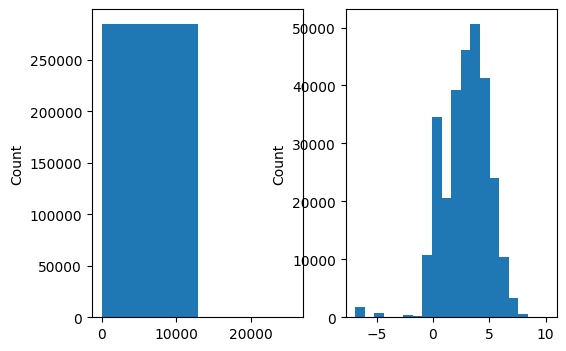

In [34]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6,4))

df['Amount'].plot(kind='hist', bins=2, ax=ax1)
ax1.set_ylabel('Count')

preprocess_df['Amount'].plot(kind='hist', bins=20, ax=ax2)
ax2.set_ylabel('Count')

In [35]:
labels = np.array(preprocess_df.pop('Class'))

labels

array([0, 0, 0, ..., 0, 0, 0])

In [36]:
features = preprocess_df.values
features.shape


(284807, 30)

/var/folders/dr/74f443cx0ljg_9kz1_q1ylv80000gn/T/ipykernel_10069/2626068526.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=labels, palette='Set2')


<Axes: ylabel='count'>

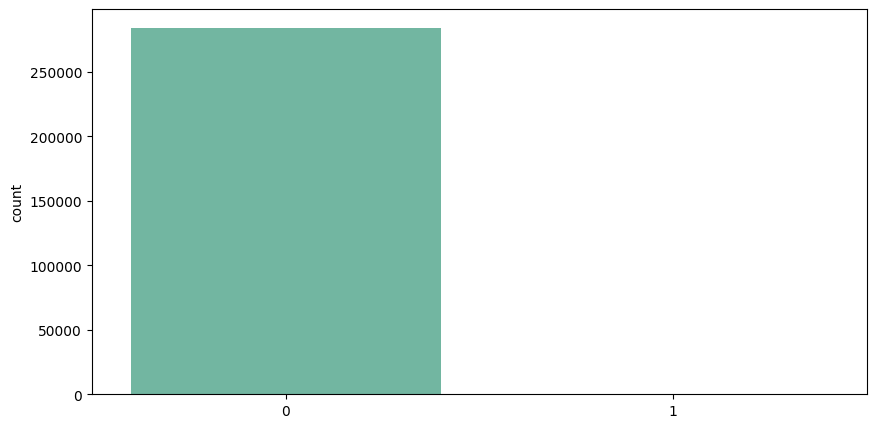

In [45]:
plt.figure(figsize=(10, 5))
sns.countplot(x=labels, palette='Set2')

### Dataset 을 Training 과 Test set 으로 분리

In [48]:
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.5, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((142403, 30), (142404, 30), (142403,), (142404,))

In [51]:
print(f'전체 data의 positive 건수 : ', Counter(labels))
print(f'Training set의 positive 건수 : ', Counter(y_train))
print(f'Test set의 positive 건수 : ', Counter(y_test))

전체 data의 positive 건수 :  Counter({np.int64(0): 284315, np.int64(1): 492})
Training set의 positive 건수 :  Counter({np.int64(0): 142157, np.int64(1): 246})
Test set의 positive 건수 :  Counter({np.int64(0): 142158, np.int64(1): 246})


## Feature Scaling

In [55]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


### Metrics 정의
- model train 중 측정할 metric  정의

## Simple NN model 정의 - 이진 분류 모델

In [75]:
class Mymodel(nn.Module):
    def __init__(self, input_dim):
        super(Mymodel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),  # input_dim을 동적으로 설정
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

# 모델 생성
input_dim = X_train.shape[-1]  # 입력 차원
model = Mymodel(input_dim)

# 손실 함수 및 옵티마이저 정의
criterion = nn.BCELoss()  # 'binary_crossentropy'와 동일
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 평가 메트릭 추가 (PyTorch는 기본 제공되지 않으므로 직접 계산)
print(model)

Mymodel(
  (model): Sequential(
    (0): Linear(in_features=30, out_features=32, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.2, inplace=False)
    (3): Linear(in_features=32, out_features=16, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.2, inplace=False)
    (6): Linear(in_features=16, out_features=1, bias=True)
    (7): Sigmoid()
  )
)


### Baseline model build

In [65]:
Epoch = 100
Batch_size = 2048


## Train the model

In [68]:
# 데이터셋 준비
train_dataset = TensorDataset(torch.tensor(X_train, dtype=torch.float32), 
                               torch.tensor(y_train, dtype=torch.float32))
test_dataset = TensorDataset(torch.tensor(X_test, dtype=torch.float32), 
                              torch.tensor(y_test, dtype=torch.float32))

train_loader = DataLoader(train_dataset, batch_size=Batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=Batch_size, shuffle=False)


In [76]:
for epoch in range(Epoch):
    model.train()  
    train_loss = 0.0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch).squeeze()  
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    model.eval()  
    val_loss = 0.0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_out = model(X_batch).squeeze()  
            loss = criterion(y_out, y_batch)
            val_loss += loss.item()

            y_true.extend(y_batch.tolist())
            y_pred.extend(y_out.tolist())

    val_auc = roc_auc_score(y_true, y_pred)
    print(f"Epoch {epoch+1}/{Epoch} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}")


Epoch 1/100 - Train Loss: 4.6301, Val Loss: 0.3993, Val AUC: 0.9545
Epoch 2/100 - Train Loss: 0.3589, Val Loss: 0.3725, Val AUC: 0.9619
Epoch 3/100 - Train Loss: 0.3161, Val Loss: 0.3437, Val AUC: 0.9669
Epoch 4/100 - Train Loss: 0.2903, Val Loss: 0.3437, Val AUC: 0.9652
Epoch 5/100 - Train Loss: 0.2820, Val Loss: 0.3482, Val AUC: 0.9676
Epoch 6/100 - Train Loss: 0.2645, Val Loss: 0.3239, Val AUC: 0.9693
Epoch 7/100 - Train Loss: 0.2572, Val Loss: 0.3245, Val AUC: 0.9698
Epoch 8/100 - Train Loss: 0.2564, Val Loss: 0.3366, Val AUC: 0.9691
Epoch 9/100 - Train Loss: 0.2410, Val Loss: 0.3283, Val AUC: 0.9670
Epoch 10/100 - Train Loss: 0.2206, Val Loss: 0.3596, Val AUC: 0.9656
Epoch 11/100 - Train Loss: 0.2096, Val Loss: 0.3539, Val AUC: 0.9660
Epoch 12/100 - Train Loss: 0.2063, Val Loss: 0.3672, Val AUC: 0.9663
Epoch 13/100 - Train Loss: 0.2126, Val Loss: 0.3700, Val AUC: 0.9653
Epoch 14/100 - Train Loss: 0.2033, Val Loss: 0.3415, Val AUC: 0.9680
Epoch 15/100 - Train Loss: 0.1950, Val Loss

## Evaluate Metric

- confusion matrix 를 이용하여 metrics 요약

f1 score: 0.7908902691511387
Accuracy 0.9992907502598242
Precision 0.8059071729957806
Recall 0.7764227642276422


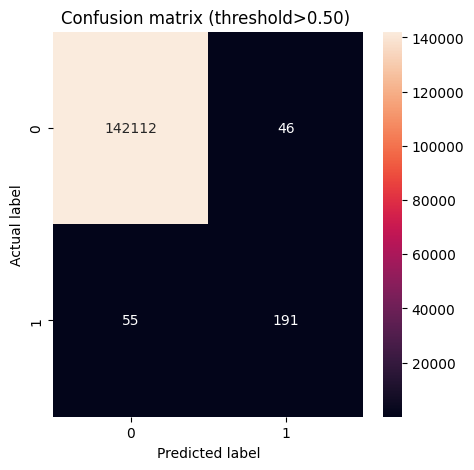

In [89]:
from sklearn.metrics import confusion_matrix

def confusion_matrix_plot(y_true, y_pred, threshold):
    cm = confusion_matrix(y_true, [1 if pred > threshold else 0 for pred in y_pred])

    print("f1 score:", f1_score(y_true, [1 if pred > threshold else 0 for pred in y_pred]))
    print("Accuracy", accuracy_score(y_true, [1 if pred > threshold else 0 for pred in y_pred]))
    print("Precision", precision_score(y_true, [1 if pred > threshold else 0 for pred in y_pred]))
    print("Recall", recall_score(y_true, [1 if pred > threshold else 0 for pred in y_pred]))

    plt.figure(figsize=(5,5))
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title('Confusion matrix (threshold>{:.2f}) '.format(threshold))
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')

confusion_matrix_plot(y_test, y_pred, 0.5)


### Test dataset 으로 모델을 평가 하고, confusion matrix 를 그린다

## Class Weight 조정

사용할 positive 샘플이 많지 않기 때문에 가용한 적은 수의 sample 에 classifier 가 더 비중을 두도록 할 수 있다.  이는 모델이 과소 표현된 클래스의 샘플에 `더 많은주의를 기울이도록` 지시하는 데 유용.

step1 - 레이블 및 관련 가중치로 dictionary 정의
```
class_weight ={0: 0.5008652375006595, 1: 289.43800813008136}
```                
step2 - dictionary를 매개 변수로 공급:  
```
    model.fit(X_train, Y_train, nb_epoch=5, batch_size=32, class_weight=class_weight)
```

- loss function 계산 시 class_weight 에 지정된 대로 가중 평균

In [90]:
neg, pos, total

(284315, 492, 284807)

In [91]:
weight_for_0 = (1 / neg) * (total) / 2
weight_for_1 = (1 / pos) * (total) / 2

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


In [92]:
class_weight

{0: 0.5008652375006595, 1: 289.43800813008136}

In [94]:
class_weight = torch.tensor([class_weight[0], class_weight[1]])

In [95]:
class_weight

tensor([  0.5009, 289.4380])

In [96]:
# 모델 정의
class WeightedModel(nn.Module):
    def __init__(self, input_dim):
        super(WeightedModel, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 32),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(16, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)

input_dim = X_train.shape[-1]
model = WeightedModel(input_dim)

# 손실 함수에서 클래스 가중치 적용
# 가중치는 Tensor 형태로 전달
criterion = nn.BCELoss(weight=class_weight[1])

# 옵티마이저 정의
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 학습 루프
EPOCHS = 100
for epoch in range(EPOCHS):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch).squeeze()
        loss = criterion(y_pred, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    # 유효성 검증
    model.eval()
    val_loss = 0.0
    y_true = []
    y_pred = []
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_out = model(X_batch).squeeze()
            loss = criterion(y_out, y_batch)
            val_loss += loss.item()

            y_true.extend(y_batch.tolist())
            y_pred.extend(y_out.tolist())

    # AUC 계산
    val_auc = roc_auc_score(y_true, y_pred)
    print(f"Epoch {epoch+1}/{EPOCHS} - Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val AUC: {val_auc:.4f}")

Epoch 1/100 - Train Loss: 1337.6132, Val Loss: 109.6012, Val AUC: 0.9624
Epoch 2/100 - Train Loss: 101.8574, Val Loss: 108.3411, Val AUC: 0.9680
Epoch 3/100 - Train Loss: 95.1035, Val Loss: 98.6620, Val AUC: 0.9727
Epoch 4/100 - Train Loss: 88.9766, Val Loss: 104.6216, Val AUC: 0.9689
Epoch 5/100 - Train Loss: 80.5959, Val Loss: 101.1584, Val AUC: 0.9696
Epoch 6/100 - Train Loss: 78.2090, Val Loss: 99.9538, Val AUC: 0.9727
Epoch 7/100 - Train Loss: 75.8725, Val Loss: 101.2188, Val AUC: 0.9695
Epoch 8/100 - Train Loss: 71.7178, Val Loss: 100.6758, Val AUC: 0.9703
Epoch 9/100 - Train Loss: 68.8960, Val Loss: 98.7583, Val AUC: 0.9698
Epoch 10/100 - Train Loss: 66.6917, Val Loss: 102.5204, Val AUC: 0.9673
Epoch 11/100 - Train Loss: 60.2388, Val Loss: 101.0792, Val AUC: 0.9668
Epoch 12/100 - Train Loss: 61.9302, Val Loss: 95.4013, Val AUC: 0.9705
Epoch 13/100 - Train Loss: 58.4499, Val Loss: 96.9343, Val AUC: 0.9726
Epoch 14/100 - Train Loss: 60.7583, Val Loss: 97.4517, Val AUC: 0.9722
Epoc

f1 score: 0.7833333333333333
Accuracy 0.9992696834358585
Precision 0.8034188034188035
Recall 0.7642276422764228


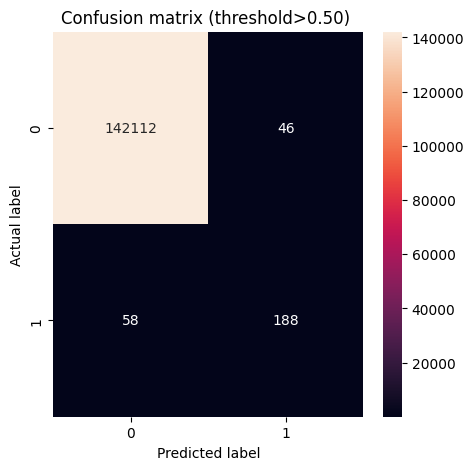

In [99]:
# 모델을 평가 모드로 설정
model.eval()

# 예측 수행
with torch.no_grad():
    predictions_weighted = model(torch.tensor(X_test, dtype=torch.float32)).squeeze()

predictions_weighted = predictions_weighted.numpy()

confusion_matrix_plot(y_test, predictions_weighted, 0.5)

각 클래스의 샘플 수에 반비례하는 가중치를 계산하여, 모델 학습 시 소수 클래스의 중요도를 증가시키고 다수 클래스의 중요도를 감소시킵니다. 이 방법은 모델이 소수 클래스를 더 잘 학습하도록 돕습니다.

## Plot the ROC

## Next Step => Over+Under-sampling model과 weight 조절 DNN model 비교